In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.filtered.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.filtered.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
44484,chr16,223472,223709,unfragmented.filtered.rvs_peak_9279,22749,584.04822,2282.51392,2274.95264,775.0,15,.,Unannotated,-,LSM11,RBP,0.0,0.0,Antisense
44485,chr16,230338,230554,unfragmented.filtered.rvs_peak_9282,19190,486.79642,1926.43616,1919.02112,691.0,12,.,Unannotated,-,NCBP2,RBP,0.0,0.0,Antisense
44486,chr16,227336,227447,unfragmented.filtered.rvs_peak_9281,18672,487.01907,1874.54541,1867.29785,660.0,12,.,Unannotated,-,YBX3,RBP,0.0,0.0,Antisense
0,chr11,65273309,65273587,unfragmented.filtered.fwd_peak_5081,21145,505.96466,2121.81445,2114.55933,512.0,15,GTF2F1,RBP,+,TALAM1,Long RNA,0.0,0.0,Sense
1,chr16,24228399,24228506,unfragmented.filtered.fwd_peak_10480,16391,413.05743,1646.16150,1639.16919,420.0,14,GA-rich,Repeats,+,.,Unannotated,0.0,0.0,Sense


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


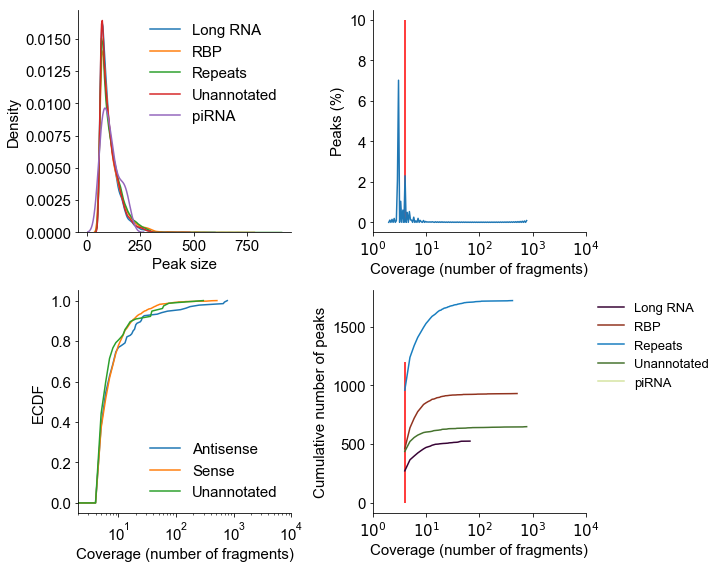

In [33]:
fig = plt.figure(figsize=(10,8))
size_ax = fig.add_subplot(221)
cov_ax = fig.add_subplot(222)
number_ax = fig.add_subplot(224)
dist_cov_ax = fig.add_subplot(223)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_size(peak_df, ax = size_ax)
size_ax.legend(fontsize=15, frameon=False)
plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [34]:
peak_df.sense_gtype.unique()

array(['Unannotated', 'RBP', 'Repeats', 'Long RNA', 'piRNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


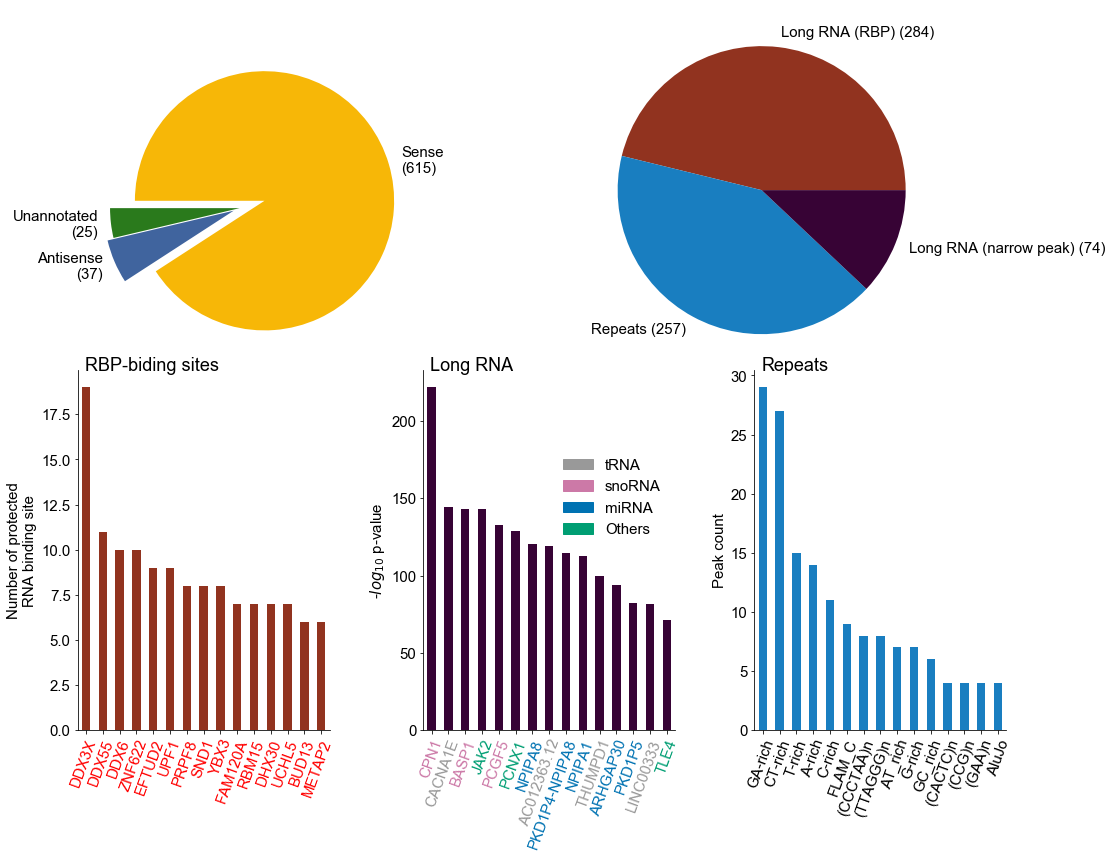

In [35]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_repeats_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
fig.text(-0.09,0.5, 'RBP-biding sites', fontsize=18)
fig.text(0.39,0.5, 'Long RNA', fontsize=18)
fig.text(0.85,0.5, 'Repeats', fontsize=18)

figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [ ]:
ec = ecoli_mapper()
a = ec.ecoli_map('chr9',9029412,90294292)
a

In [ ]:
ec = ecoli_mapper()
peak_df\
    .query('sample_count >= %i & sense_gtype=="Long RNA"' %(sample_cutoff))\
    .nlargest(20,'log10q')\
    .reset_index(drop=True)\
    .assign(is_ecoli = lambda d: list(map(ec.ecoli_map,d.chrom, d.start, d.end))) \
    .assign(seq = lambda d:  list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(mt = lambda d: d.seq.map(is_mt))

# Intron #

In [74]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
full_peak = pd.read_table(peak_path + '/unfragmented.unfiltered.tsv')
intron_df = BedTool()\
    .from_dataframe(full_peak)\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-

***** WARNING: File /stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed has inconsistent naming convention for record:
chr1	135896	137620	ENSG00000237683.5	0	-



(117, 24)

In [91]:
intron_df \
    .query('pileup >= 5 & sample_count >= 5' )\
    .filter(['chrom','start','end','peakname','sense_gname'])\
    .drop_duplicates()\
    .reset_index(drop=True) \
    .assign(size = lambda d: d.end - d.start)

,chrom,start,end,peakname,sense_gname,size
0,chr19,11333582,11333668,unfragmented.unfiltered.rvs_peak_13246,EFTUD2,86
1,chr22,50356514,50356587,unfragmented.unfiltered.fwd_peak_19911,MIR6821,73
2,chr17,39913789,39913885,unfragmented.unfiltered.rvs_peak_11575,XPO5,96
3,chr16,18430618,18430707,unfragmented.unfiltered.rvs_peak_10144,RP11-1212A22.1,89
4,chr16,15027134,15027223,unfragmented.unfiltered.fwd_peak_10945,RP11-958N24.1,89
5,chr16,2149772,2149861,unfragmented.unfiltered.rvs_peak_9922,EFTUD2,89
6,chr15,91423005,91423096,unfragmented.unfiltered.fwd_peak_10518,XPO5,91
7,chr16,18470720,18470809,unfragmented.unfiltered.rvs_peak_10146,RP11-1212A22.4,89
8,chr16,16425621,16425710,unfragmented.unfiltered.fwd_peak_10961,PKD1P1,89
9,chr17,73500562,73500652,unfragmented.unfiltered.rvs_peak_12022,CASKIN2,90


In [92]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []       

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,FDR,is_sense,intron_chrom,intron_start,intron_end,intron_gene,intron_score,intron_strand,seq,dinucleotide
0,chr19,11333582,11333668,unfragmented.unfiltered.rvs_peak_13246,13842,375.16605,1390.00916,1384.28540,389.0,15,...,11333582,11333668,ENSG00000130158.9,0,-,NaN,NaN,NaN,GTAGGAGTGGGCGTGGGCAGGGTGGGCATGGCATGGATGGAAGGCG...,GT:CA
1,chr22,50356514,50356587,unfragmented.unfiltered.fwd_peak_19911,3828,119.13328,388.20734,382.81543,122.0,14,...,50356514,50356587,ENSG00000198355.4,0,+,NaN,NaN,NaN,TGCGTGGTGGCTCGAGGCGGGGGTGGGGGCCTCGCCCTGCTTGGGC...,TG:AG
2,chr17,39913789,39913885,unfragmented.unfiltered.rvs_peak_11575,1262,45.64637,131.23683,126.22630,46.0,15,...,39913789,39913885,ENSG00000173801.12,0,-,NaN,NaN,NaN,GTGAGCTGGGGGAGGGCAGGAGGCTGGGTCCCACTCCCCCAGCCAC...,GT:CA
3,chr16,18430618,18430707,unfragmented.unfiltered.rvs_peak_10144,1092,42.15805,114.26573,109.28957,43.0,14,...,18430618,18430707,ENSG00000214940.4,0,-,NaN,NaN,NaN,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,GT:CA
4,chr16,15027134,15027223,unfragmented.unfiltered.fwd_peak_10945,1018,40.75145,106.90894,101.89374,42.0,13,...,15027134,15027223,ENSG00000183426.11,0,+,NaN,NaN,NaN,TGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTCC...,TG:AG


In [93]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

Written:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/intron_table.csv


In [98]:
seqfile = peak_path  + '/unfragmented.intron.fa'
with open(seqfile, 'w')  as fa:
    for i, row in intron_df\
            .query('pileup >= 5 & sample_count >= 5' )\
            .filter(['seq'])\
            .drop_duplicates()\
            .iterrows():
        print('>%s\n%s' %('peak'+str(i), row['seq']), file = fa)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [ ]:
','.join(rbp_df.head(15).index)

In [ ]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [ ]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

In [ ]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [85]:
    rbp_count = defaultdict(int)
    for i, row in peaks.query('pileup >= %i & sample_count >= %i' %(pileup_cutoff, sample_cutoff)).iterrows():
        added = set()
        for btype, bp in zip(row['sense_gtype'].split(','),
                        row['sense_gname'].split(',')):
            if btype == "RBP":
                if bp not in added:
                    rbp_count[bp] += 1
                    added.add(bp)

    rbp_df = pd.DataFrame\
        .from_dict(rbp_count, orient='index')\
        .sort_values(0, ascending=False)

In [90]:
','.join(rbp_df.head(15).index)

'DDX3X,ZNF622,DDX55,DDX6,UPF1,EFTUD2,DHX30,SND1,YBX3,PRPF8,RBM15,FAM120A,UCHL5,METAP2,TRA2A'